# Potential and current in the "Greek cross"

The Greek cross geometry is similar to the Van der Pauw square in some respects. The correct implementation involves two long thin bars which cross in the middle to define a relatively small square (see "Walton.pdf"). However, we will see that some implementations neglect the "long thin" part such that any useful signal is shorted out by the contacts.

See, for example, [Flexible Hall sensors based on graphene](http://dx.doi.org/10.1039/C5NR08729E).

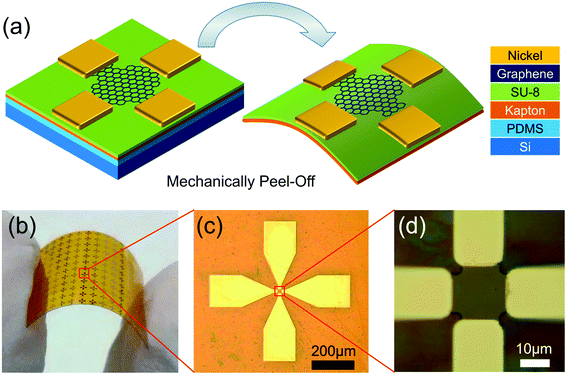

Installation instructions for fenics (legacy) can be found at https://fenicsproject.org/download/archive/

In [1]:
#! /usr/bin/env python3
# based on demo_mixed-poisson.py
# but see sections 4.1 and 4.2 in the tutorial pdf
# and https://fenicsproject.discourse.group/t/pde-system-simple-example/1550/2

# now also section 4.3 and https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/tensor-weighted-poisson/documentation.html

# Installation instructions for fenics: https://fenicsproject.org/download/archive/
# This script works with version 2019.1.0

# for Greek-cross style geometries

from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

Zero-field conductivity: 4.61e-06 Ohm-1/sq
Zero-field resistivity: 216742.96 Ohm/sq
Two-terminal resistance 346788.74 Ohm
... at B = 100.0 mT:
Hall coefficient: 65.02 Ohm/T
rho_xx = 216742.96 Ohm/sq	rho_xy = 6.50 Ohm
0.10	346788.74	216742.96	6.50	65.02	9.6000e+16	0.0003
Solving linear variational problem.
-2.142402718886487e-07
-0.0017604568447788511
Saved function f_23-0 (a Function) to file fenics-Greek-01.2_phi.xyz in xd3d xyz format.
Saved function f_50 (a Function) to file fenics-Greek-01.2_Jx.xyz in xd3d xyz format.
Saved function f_67 (a Function) to file fenics-Greek-01.2_Jy.xyz in xd3d xyz format.


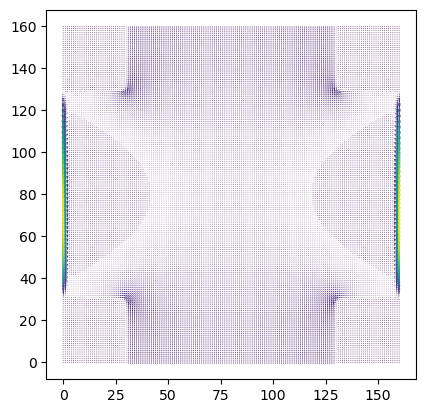

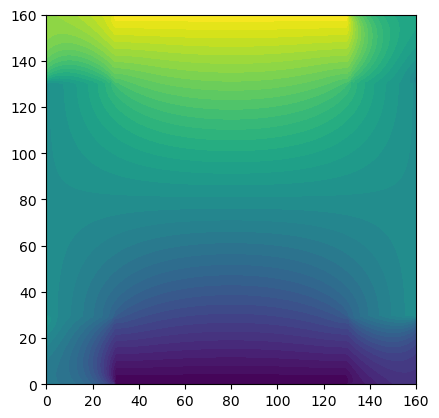

In [2]:
BarLength = 160.0
BarWidth = 100.0

CSize = (BarLength - BarWidth)/2

CSize1 = CSize
CSize2 = BarLength-CSize

ResFactor = 10

XPoints = ResFactor*16
YPoints = ResFactor*16

ResX = BarLength/XPoints
ResY = BarLength/YPoints

mu = 3.0e-4 # m2/Vs
ns = 9.6e16 # m-2
qe = 1.602e-19 # C

B = 100.0e-3 # T

cond0 = ns*qe*mu
rho0 = 1/cond0
print('Zero-field conductivity: {:.2e} Ohm-1/sq'.format(cond0))
print('Zero-field resistivity: {:.2f} Ohm/sq'.format(rho0))

R2 = rho0*BarLength/BarWidth
RH = 1/(qe*ns)
print('Two-terminal resistance {:.2f} Ohm'.format(R2))
print('... at B = {:.1f} mT:'.format(1e3*B))
print('Hall coefficient: {:.2f} Ohm/T'.format(RH))
print('rho_xx = {:.2f} Ohm/sq\trho_xy = {:.2f} Ohm'.format(rho0,B*RH))

print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.4e}\t{:.4f}'.format(B,R2,rho0,B*RH,RH,ns,mu))

# Create mesh
mesh = RectangleMesh(Point(0.0, 0.0), Point(BarLength, BarLength), XPoints, YPoints, "right/left")


el_scalar = FiniteElement("Lagrange", mesh.ufl_cell(), 1)  # potential
el_vector = VectorElement("Lagrange", mesh.ufl_cell(), 2)  # current density
el = MixedElement([el_scalar, el_vector])
Vmixed = FunctionSpace(mesh, el)
v, tau = TestFunctions(Vmixed)
u, sigma = TrialFunctions(Vmixed)

phi = Vmixed.sub(0)
J = Vmixed.sub(1)

# Semiconductor
csemixx = cond0/(1+mu*mu*B*B)
csemixy = cond0*mu*B/(1+mu*mu*B*B)
# Voltage probes
ccontact = Constant(cond0*1e3)
ccontactH = Constant(0.0)
# Missing corners
chole = Constant(cond0*1e-3)
choleH = Constant(0.0)

f = Constant(0.0)

class Sxx(UserExpression):
    def set_cond_values(self, csemixx, ccontact, chole):
        self.csemixx, self.ccontact, self.chole = csemixx, ccontact, chole

    def eval(self, value, x):
        if x[0] < CSize1 and (x[1] < CSize1 or x[1] > CSize2):
            value[0] = self.chole

        elif x[0] > CSize2 and (x[1] < CSize1 or x[1] > CSize2):
            value[0] = self.chole

        elif x[0] > CSize1 and x[0] < CSize2 and (x[1] < 0.0 + ResY or x[1] > BarLength - ResY):
            value[0] = self.ccontact

        elif x[1] > CSize1 and x[1] < CSize2 and (x[0] < 0.0 + ResX or x[0] > BarLength - ResX):
            value[0] = self.ccontact

        else:
            value[0] = self.csemixx

class Sxy(UserExpression):
    def set_cond_values(self, csemixy, ccontactH, choleH):
        self.csemixy, self.ccontactH, self.choleH = csemixy, ccontactH, chole

    def eval(self, value, x):
        if x[0] < CSize1 and (x[1] < CSize1 or x[1] > CSize2):
            value[0] = self.choleH

        elif x[0] > CSize2 and (x[1] < CSize1 or x[1] > CSize2):
            value[0] = self.choleH

        elif x[0] > CSize1 and x[0] < CSize2 and (x[1] < 0.0 + ResY or x[1] > BarLength - ResY):
            value[0] = self.ccontactH

        elif x[1] > CSize1 and x[1] < CSize2 and (x[0] < 0.0 + ResX or x[0] > BarLength - ResX):
            value[0] = self.ccontactH

        else:
            value[0] = self.csemixy

#Initialize conductivity
condxx = Sxx(mesh, degree=0)
condxy = Sxy(mesh, degree=0)
condxx.set_cond_values(csemixx,ccontact,chole)
condxy.set_cond_values(csemixy,ccontactH,choleH)

cond = as_matrix(((condxx,condxy),(-condxy,condxx)))

#condSpace = FunctionSpace(mesh,'DG',0)
#condPlot = project(condxx,condSpace)
#plot(condPlot)
#plt.show()
#condPlot = project(condxy,condSpace)
#plot(condPlot)
#plt.show()

#cond = as_matrix(((S[0],S[1]),(-S[1],S[0])))

F = dot(cond*grad(u) + sigma, tau) * dx + dot(sigma, grad(v)) * dx - f * v * dx

# Define function G such that G \cdot n = g
class BoundarySource(UserExpression):
    def __init__(self, mesh, **kwargs):
        self.mesh = mesh
        super().__init__(**kwargs)
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = 0.0
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)

G = BoundarySource(mesh, degree=2)

# Define essential boundary
def boundary(x, on_boundary):
    return on_boundary # (x[1] < 0.0 + ResY or x[1] > BarLength - ResY)

bc_Sides = DirichletBC(J, G, boundary, method='pointwise')

# Define current drain and source

Vdrain=3.000

u_D = Constant(Vdrain)
u_S = Constant(0.000)

# define all four contacts:

def boundary_1(x, on_boundary):
    return (x[0] > CSize1 - ResX) and (x[0] < CSize2 + ResX) and (x[1] < ResY) # "VC-"

def boundary_2(x, on_boundary):
    return (x[1] > CSize1 - ResY) and (x[1] < CSize2 + ResY) and (x[0] < ResX) # "VHleft"

def boundary_3(x, on_boundary):
    return (x[0] > CSize1 - ResX) and (x[0] < CSize2 + ResX) and (x[1] > BarLength - ResY) # "VC+"

def boundary_4(x, on_boundary):
    return (x[1] > CSize1 - ResY) and (x[1] < CSize2 + ResY) and (x[0] > BarLength - ResX) # "VHright"

bc_D = DirichletBC(phi, u_D, boundary_3, method='pointwise')
bc_S = DirichletBC(phi, u_S, boundary_1, method='pointwise')

# corners of domain where holes are:

def boundary_holes(x, boundary):
    return (x[0] < CSize1 or x[0] > CSize2 or x[1] < CSize1 or x[1] > CSize2) 

bc_H = DirichletBC(phi, u_S, boundary_holes, method='pointwise')

# Collect boundary conditions

bc = [bc_D, bc_S, bc_Sides]

u = Function(Vmixed)

solve(lhs(F) == rhs(F), u, bc)

phi, J = u.split()

# calculate total current flux in x and y directions

total_current_x = assemble(J[0]*dx)
total_current_y = assemble(J[1]*dx)
print(total_current_x)
print(total_current_y)

plt.figure('current density')
plot(J)

xhat = as_vector((1.0,0.0))
yhat = as_vector((0.0,1.0))
Jx = dot(J, xhat)
Jy = dot(J, yhat)
Jx_proj = project(Jx, FunctionSpace(mesh, el_scalar))
Jy_proj = project(Jy, FunctionSpace(mesh, el_scalar))

#plt.figure('current density in x direction')
#plot(Jx)
#plt.figure('current density in y direction')
#plot(Jy)

plt.figure('potential')
plot(phi)

# Save potential
phi_file = File("fenics-Greek-01.2_phi.xyz")
phi_file << phi

# Save J
J_file = File("fenics-Greek-01.2_J.pvd")
J_file << J

# Save Jx and Jy
Jx_file = File("fenics-Greek-01.2_Jx.xyz")
Jy_file = File("fenics-Greek-01.2_Jy.xyz")
Jx_file << Jx_proj
Jy_file << Jy_proj

plt.show()

In [ ]:
phi_file = 'fenics-Greek-01.2_phi000000.xyz'
Jx_file = 'fenics-Greek-01.2_Jx000000.xyz'
Jy_file = 'fenics-Greek-01.2_Jy000000.xyz'

phix, phiy, phival = np.loadtxt(phi_file, unpack=True)
#Jxx, Jxy, Jxval = np.loadtxt(Jx_file, unpack=True)
Jyx, Jyy, Jyval = np.loadtxt(Jy_file, unpack=True)

nsheet=ns
musim=mu

RH = 1/(qe*nsheet) # 1/ne

rho0 = 1/(nsheet*qe*musim) # true rho

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def getPotential(position):
    #print(position)
    possiblex = np.where(np.abs(phix - position[0])<0.5*ResX)
    #print(possiblex[0])
    possibley = np.where(np.abs(phiy - position[1])<0.5*ResY)
    #print(possibley[0])
    onlyxy = np.intersect1d(possiblex,possibley)
    return phival[onlyxy]

def getCurrent(position):
    #print(position)
    line = np.where(np.abs(Jyy - position)<0.5*ResY)
    Jyline = -Jyval[line]
    Jyposx = Jyx[line]
    #print(Jyval)
    Itot = np.trapz(Jyline,x=Jyposx)
    return Itot

# voltage probe positions:
probeL = np.array((ResX,BarLength/2))
probeR = np.array((BarLength-ResX,BarLength/2))

VHL = getPotential(probeL)[0]
VHR = getPotential(probeR)[0]

VH = VHL-VHR

# current integration line position in y:
currenty = 0.5*BarLength

Idrain = getCurrent(currenty)

R2 = Vdrain/Idrain
VdP = 4.53236 # pi/ln(2)

print('length/width = {:.4f}'.format(BarLength/BarWidth))

RS = BarWidth/BarLength*R2

print('actual factor between true rho and measured two-terminal resistance is {:.4f}'.format(rho0/R2))

#S_V = 1/Vdrain*VH/B # eq. (1)
#S_1 = 1/Idrain*VH/B # eq. (2)

#mu_H = BarLength/BarWidth*S_V # eq. (3)
#n_H = 1/(S_1*qe) # eq. (4)


print('for n_s {:.2e} cm-2'.format(nsheet*1e-4))
print('muSIM = {:.2f} cm^2/Vs in simulation'.format(1e4*musim))

print('true rho {:.2f} Ohm/sq.'.format(rho0))
print('I_ds = {:.4f} uA measured for V_ds = {:.4f} V applied'.format(1e6*Idrain,Vdrain))
print('Two-terminal resistance {:.2f} Ohm'.format(R2))
if B!=0:
    print('V_H = {:.3f} mV measured at probes'.format(1e3*VH))
    print('dV_H/dB = {:.3f} mV/T'.format(1e3*VH/B))
    #print('S_V = {:.3f} V VT-1 eq. (1)'.format(S_V))
    #print('S_1 = {:.1f} V AT-1 eq. (2)'.format(S_1))

    #print('mu_H  = {:.2f} cm^2/Vs'.format(1e4*mu_H))
    #print('n_H {:.2e} cm-2'.format(n_H*1e-4))

#print('{:.2e}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(nsheet/1e4,R2,RS,1e4*musim,1e4*mu_H))